#**Hierarchical Attention Network**

###**Installations**

In [ ]:
# Tokenization
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py    

In [ ]:
!pip install --upgrade gensim
!pip install xgboost
!pip install snowballstemmer
!pip install sentencepiece
!pip install pyspell

     |████████████████████████████████| 24.2MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.2MB 13.1MB/s 
ERROR: Could not find a version that satisfies the requirement pyspell (from versions: none)
ERROR: No matching distribution found for pyspell


In [ ]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###**Package Imports**

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
from bs4 import BeautifulSoup
import logging
import os
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import tokenization
from wordcloud import STOPWORDS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from wordcloud import WordCloud
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, Input, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from collections import defaultdict
from collections import Counter

from PIL import Image
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

plt.style.use('ggplot')
stop=set(stopwords.words('english'))
%matplotlib inline


###**Data loading**

In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/df_main.csv')

df_main['review'] = df_main['review'].values.astype('U')
df_main = df_main.reset_index()


###**Define embedding params**

In [ ]:
MAX_SENT_LENGTH = 64
MAX_SENTS = 64
MAX_NB_WORDS = 35000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.15

In [ ]:
reviews = []
texts = []
for i in range(df_main['review'].shape[0]):
    text = df_main['review'][i]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

###**Tokenize**

In [ ]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [ ]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 37000 unique tokens.


In [ ]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(np.asarray(df_main['target']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (114906, 64, 64)
Shape of label tensor: (114906, 2)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

###**Train/val split**

In [ ]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

###**UploadGlove**

In [ ]:
GLOVE_DIR = "/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/Final Project/glove.6B.100d.txt"

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


###Embedding definitions

In [ ]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

###Model Architecture

In [ ]:

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(2, activation='sigmoid')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Hierachical LSTM")
model.summary()

Hierachical LSTM
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 200)           3860900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 4,102,102
Trainable params: 402,002
Non-trainable params: 3,700,100
_________________________________________________________________


###Run model

In [ ]:
cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=64,callbacks=[cp])

Epoch 1/20
1527/1527 [==============================] - 146s 81ms/step - loss: 0.5467 - acc: 0.7176 - val_loss: 0.3829 - val_acc: 0.8298

Epoch 00001: val_acc improved from -inf to 0.82977, saving model to model_han_.hdf5
Epoch 2/20
1527/1527 [==============================] - 122s 80ms/step - loss: 0.3588 - acc: 0.8418 - val_loss: 0.4010 - val_acc: 0.8117

Epoch 00002: val_acc did not improve from 0.82977
Epoch 3/20
1527/1527 [==============================] - 122s 80ms/step - loss: 0.2909 - acc: 0.8764 - val_loss: 0.2822 - val_acc: 0.8804

Epoch 00003: val_acc improved from 0.82977 to 0.88042, saving model to model_han_.hdf5
Epoch 4/20
1527/1527 [==============================] - 123s 80ms/step - loss: 0.2366 - acc: 0.9017 - val_loss: 0.2754 - val_acc: 0.8881

Epoch 00004: val_acc improved from 0.88042 to 0.88813, saving model to model_han_.hdf5
Epoch 5/20
1527/1527 [==============================] - 123s 80ms/step - loss: 0.1932 - acc: 0.9244 - val_loss: 0.2427 - val_acc: 0.9049

Ep

###Predict on Testing set

In [ ]:
accr = model.evaluate(x_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

539/539 [==============================] - 13s 25ms/step - loss: 0.2806 - acc: 0.9481
Test set
  Loss: 0.281
  Accuracy: 0.948


###Plot loss/acc

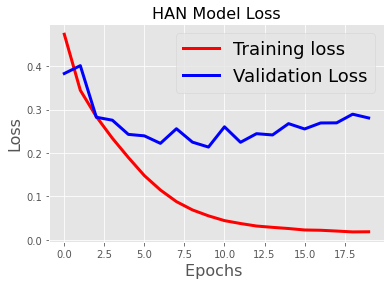

In [ ]:

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('HAN Model Loss',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

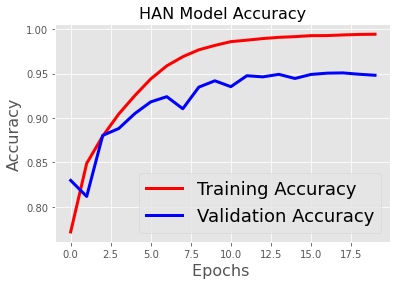

In [ ]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('HAN Model Accuracy',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()